In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1700
stride=600

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [4]:
X.shape

(8083, 1700, 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [6]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.layers import BatchNormalization


no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X.shape[1],X.shape[2])))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(BatchNormalization())


            
cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1698, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, 1696, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 424, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 27136)             0         
                                                                 
 dense (Dense)               (None, 100)               2713700   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

In [7]:
batch_size =64
epochs = 25
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/25
89/89 [==============================] - 41s 435ms/step - loss: 1.6809 - accuracy: 0.3538 - val_loss: 1.2885 - val_accuracy: 0.4441
Epoch 2/25
89/89 [==============================] - 37s 419ms/step - loss: 1.2179 - accuracy: 0.5368 - val_loss: 1.1837 - val_accuracy: 0.6326
Epoch 3/25
89/89 [==============================] - 37s 419ms/step - loss: 0.8984 - accuracy: 0.6898 - val_loss: 1.4137 - val_accuracy: 0.4305
Epoch 4/25
89/89 [==============================] - 37s 415ms/step - loss: 0.6877 - accuracy: 0.7807 - val_loss: 1.0724 - val_accuracy: 0.6363
Epoch 5/25
89/89 [==============================] - 38s 422ms/step - loss: 0.5113 - accuracy: 0.8505 - val_loss: 1.2524 - val_accuracy: 0.5551
Epoch 6/25
89/89 [==============================] - 38s 425ms/step - loss: 0.3815 - accuracy: 0.8883 - val_loss: 0.8727 - val_accuracy: 0.7212
Epoch 7/25
89/89 [==============================] - 38s 433ms/step - loss: 0.2931 - accuracy: 0.9224 - val_loss: 0.8908 - val_accuracy: 0.6759

76/76 [==============================] - 4s 54ms/step


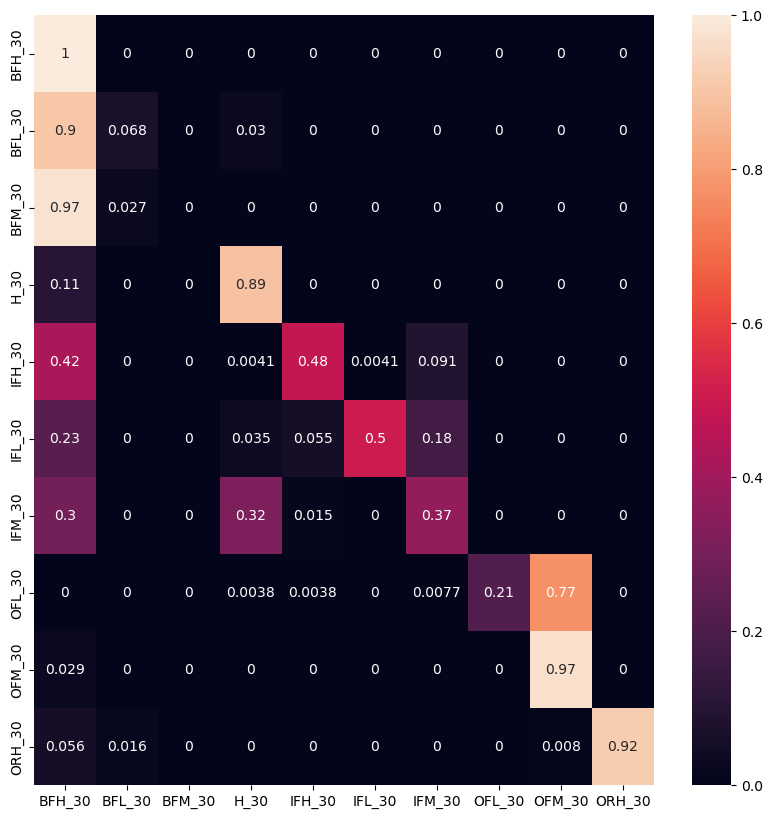

In [11]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [12]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

177/177 [==============================] - 10s 58ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5658 samples in 0.002s...


C:\ProgramData\anaconda3\envs\env18102024\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5658 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5658
[t-SNE] Computed conditional probabilities for sample 2000 / 5658
[t-SNE] Computed conditional probabilities for sample 3000 / 5658
[t-SNE] Computed conditional probabilities for sample 4000 / 5658
[t-SNE] Computed conditional probabilities for sample 5000 / 5658
[t-SNE] Computed conditional probabilities for sample 5658 / 5658
[t-SNE] Mean sigma: 1.832824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.867317
[t-SNE] KL divergence after 300 iterations: 2.036325


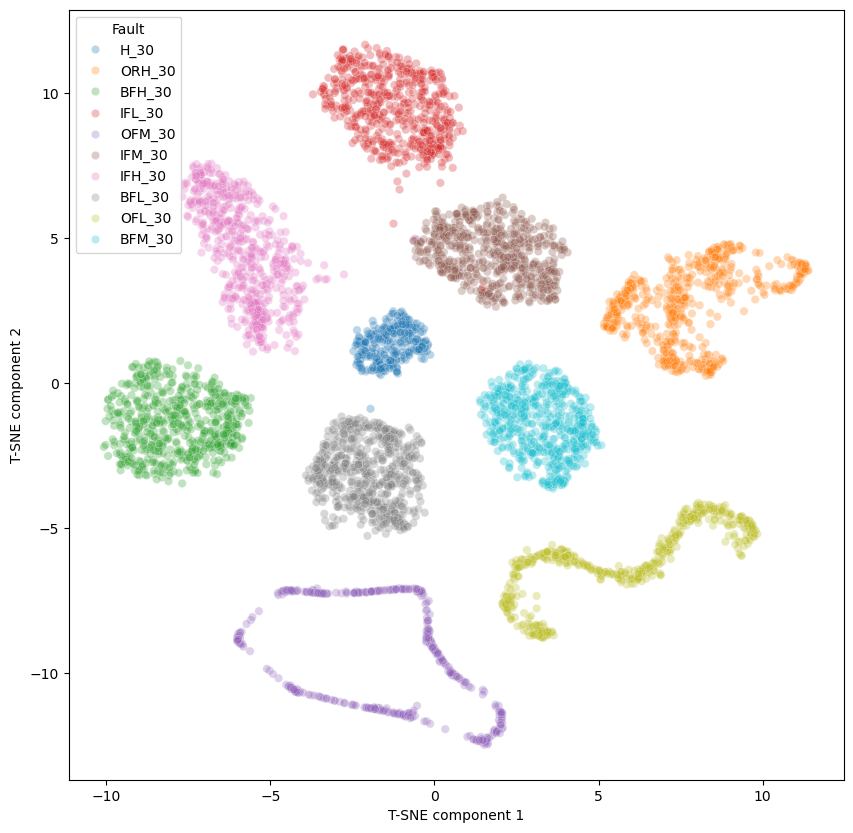

In [13]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()